In [49]:
import numpy as np
# import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import datetime
from datetime import datetime
import dateutil
import os
import calendar
import pymannkendall as mk
import itertools
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import math
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors

In [50]:
%pip install xarray
%pip install netCDF4

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [51]:
FreqCountDF = xr.open_dataset('./data/Event Data/FreqCountDF.nc')
FreqCountFD = xr.open_dataset('./data/Event Data/FreqCountFD.nc')
FreqCountDFD = xr.open_dataset('./data/Event Data/FreqCountDFD.nc')
FreqCountFDF = xr.open_dataset('./data/Event Data/FreqCountFDF.nc')
ds_df = xr.open_dataset('data/nclimgrid-spei-gamma-01.nc')
dfaami = xr.open_dataset('./data/dfaami_01.nc')
mi = xr.open_dataset('./data/mi_01.nc')
mAFDF = xr.open_dataset('./data/Event Data/meanAnnualFreq/mAFDF.nc')
mAFFD = xr.open_dataset('./data/Event Data/meanAnnualFreq/mAFFD.nc')
mag_DF = xr.open_dataset('./data/mk/mag/mk_DF_mag.nc')
mag_FD = xr.open_dataset('./data/mk/mag/mk_FD_mag.nc')

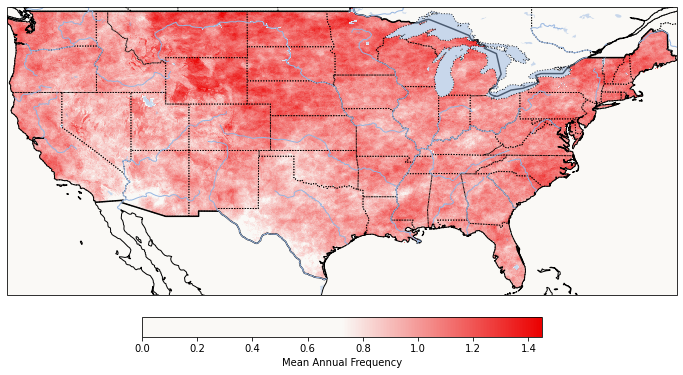

In [40]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

colors = ['#faf9f6', '#faf9f6', '#eb0000'] 
nodes = [0.0, 0.5, 1.0]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", list(zip(nodes, colors)))

custom_cmap.set_bad('white', 1.)
# norm = mcolors.TwoSlopeNorm(vmin=mAFDF['count'].min(), vcenter=0, vmax=mAFDF['count'].max())

im = ax.pcolormesh(
    mAFFD['lon'],
    mAFFD['lat'],
    mAFFD['count'],
    transform=ccrs.PlateCarree(),
    cmap=custom_cmap,
#     norm=norm,
)

ax.add_feature(cfeature.STATES, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=1.5, linestyle='-')
# ax.add_feature(states_provinces, linewidth=1.5, linestyle='-', edgecolor='k')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN,color='#E9EBE6',zorder=0,edgecolor='k')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Add title
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, fraction=0.046)
cbar.set_label('Mean Annual Frequency')

# Show the plot
plt.savefig('./data/meanAnnualFreqDF.png')
plt.show()

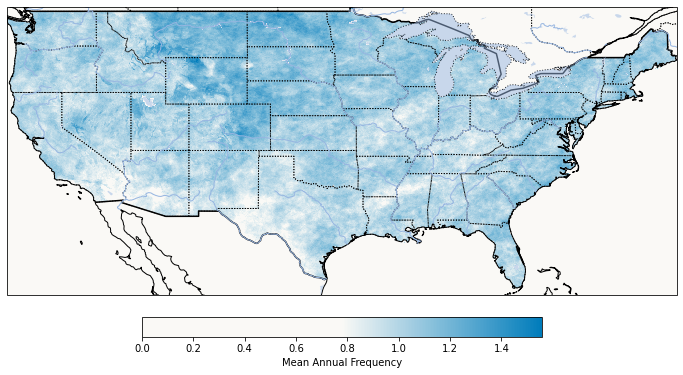

In [42]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

colors = ['#faf9f6', '#faf9f6', '#007cbb'] 
nodes = [0.0, 0.5, 1.0]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", list(zip(nodes, colors)))

custom_cmap.set_bad('white', 1.)
# norm = mcolors.TwoSlopeNorm(vmin=mAFDF['count'].min(), vcenter=0, vmax=mAFDF['count'].max())

im = ax.pcolormesh(
    mAFDF['lon'],
    mAFDF['lat'],
    mAFDF['count'],
    transform=ccrs.PlateCarree(),
    cmap=custom_cmap,
#     norm=norm,
)

ax.add_feature(cfeature.STATES, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=1.5, linestyle='-')
# ax.add_feature(states_provinces, linewidth=1.5, linestyle='-', edgecolor='k')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN,color='#E9EBE6',zorder=0,edgecolor='k')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Add title
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, fraction=0.046)
cbar.set_label('Mean Annual Frequency')

# Show the plot
plt.savefig('./data/meanAnnualFreqFD.png')
plt.show()

In [31]:
dfaami_fd  = dfaami.where(dfaami.dfaami<-0.5, np.nan)
mi_dfd = mi.where(mi.mi>0.5, np.nan)
mi_fdf = mi.where(mi.mi<-0.5, np.nan)


In [45]:
def calculate_mk(values):
    if (np.isnan(values).all()):
        return 'no trend', 0, 1.0, 0
    val = mk.original_test(values)
    return val.trend, val.h, val.p, val.slope

In [ ]:
dataset = [dfaami_fd, mi_dfd, mi_fdf]
names = ['FD', 'DFD', 'FDF']

for i in range(3):
    start = datetime.now()
    
    if i==0:
        result = xr.apply_ufunc(
            calculate_mk, 
            dataset[i].dfaami,
            input_core_dims=[['time']], 
            output_core_dims=[[], [], [], []],
            dask='parallelized',  
            vectorize=True,
        )
    else:
        result = xr.apply_ufunc(
            calculate_mk, 
            dataset[i].mi,
            input_core_dims=[['time']], 
            output_core_dims=[[], [], [], []],
            dask='parallelized',  
            vectorize=True,
        )

    print(datetime.now() - start)
    data_vars = {
        'trend': result[0],
        'h': result[1],
        'p': result[2],
        'slope': result[3]
    }
    merged_dataset = xr.Dataset(data_vars)

    merged_dataset.to_netcdf('./data/mk/mk_{}_mag.nc'.format(names[i]))

In [46]:
(mAFDF['count'] - mAFFD['count']).sum()

<xarray.DataArray 'count' ()> Size: 8B
array(5787.12403101)

In [47]:
from scipy import stats

ts1 = dfaami.dfaami.where(dfaami.dfaami>0.5).sel(lat=39.02, lon=-85.31, method='nearest')
ts2 = dfaami.dfaami.where(dfaami.dfaami<0.5).sel(lat=39.02, lon=-85.31, method='nearest')
ts3 = mi.mi.where(mi.mi>0.5).sel(lat=39.02, lon=-85.31, method='nearest')
ts4 = mi.mi.where(mi.mi<0.5).sel(lat=39.02, lon=-85.31, method='nearest')
time_series = [ts1, ts2, ts3, ts4]

count1 = FreqCountDF.__xarray_dataarray_variable__.sel(lat=39.02, lon=-85.31, method='nearest')
count2 = FreqCountFD.__xarray_dataarray_variable__.sel(lat=39.02, lon=-85.31, method='nearest')
count3 = FreqCountDFD.__xarray_dataarray_variable__.sel(lat=39.02, lon=-85.31, method='nearest')
count4 = FreqCountFDF.__xarray_dataarray_variable__.sel(lat=39.02, lon=-85.31, method='nearest')
count_series = [count1, count2, count3, count4]

trend1 = calculate_mk(FreqCountDF.__xarray_dataarray_variable__.sel(lat=39.02, lon=-85.31, method='nearest'))
trend2 = calculate_mk(FreqCountFD.__xarray_dataarray_variable__.sel(lat=39.02, lon=-85.31, method='nearest'))
trend_series = [trend1, trend2]



In [48]:
magDF = mag_DF.sel(lat = 39.02, lon=-85.31, method='nearest')
magDF

<xarray.Dataset> Size: 64B
Dimensions:  ()
Coordinates:
    lat      float32 4B 39.02
    lon      float32 4B -85.31
Data variables:
    trend    <U8 32B ...
    h        int64 8B ...
    p        float64 8B ...
    slope    int64 8B ...

In [ ]:

# Assume you have the slopes and p_values arrays
slopes = [0.02, 0.03]  # Example slopes for the two plots
p_values = [0.05, 0.03]  # Example p-values for the two plots

names = ['DF events', 'FD events', 'DFD events', 'FDF events']
for i in range(1):

    data = time_series[i].resample(time='1Y').mean(skipna=True).sel(time=slice('1985-01-01','2024-12-01'))
    years = np.arange(1985, 2024)
    mask = np.isfinite(data)

    data2 = count_series[i]
    data2 = data2.sel(year=slice('1985-01-01','2024-12-01'))
    mask2 = np.where(data2 > 0)

    fig, ax1 = plt.subplots(figsize=(9, 4), sharex=True)
    color = 'tab:blue'
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Magnitude Index', color=color)
    ax1.plot(years[mask], data[mask], color=color, label='Magnitude index')
    ax1.tick_params(axis='y', labelcolor=color)

    # Add trend line for magnitude index
    if trend[i][3] is not None:
        trend_line = trend[i][3] * years + data.mean()
        ax1.plot(years, trend_line, color='blue', linestyle='dashed', label='Trend line')
    
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Freq Count', color=color)
    ax2.plot(years[mask2], data2[mask2], color=color, label='Freq Count')
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Add trend line for frequency count
    if trend[i] is not None:
        trend_line2 = slopes[i] * years + data2.mean()
        ax2.plot(years, trend_line2, color='red', linestyle='dashed', label='Trend line')

    if i != 1:
        ax1.get_xaxis().set_visible(False)
        ax2.get_xaxis().set_visible(False)
    fig.text(0.5, 0.9, '{}'.format(names[i]), ha='center', fontsize=12)
fig.tight_layout()
plt.show()

In [113]:
FreqCountDF

<xarray.Dataset> Size: 852MB
Dimensions:                        (lat: 596, lon: 1385, year: 129)
Coordinates:
  * lat                            (lat) float32 2kB 24.56 24.6 ... 49.31 49.35
  * lon                            (lon) float32 6kB -124.7 -124.6 ... -67.02
  * year                           (year) int64 1kB 1895 1896 1897 ... 2022 2023
Data variables:
    __xarray_dataarray_variable__  (lat, lon, year) float64 852MB 0.0 ... 0.0

In [154]:
inLat = FreqCountDF['__xarray_dataarray_variable__'].sel(lat=slice(38, 42), lon=slice(-87.5, -85))
latval = inLat.lat.values
lonval = inLat.lon.values

# inLat.sel(lat=latval[0], lon=lonval[49])
# inLat['__xarray_dataarray_variable__']
# inLat.sum(dim='year', skipna=True)

In [146]:
FreqCountDF['__xarray_dataarray_variable__'].sum(dim='year', skipna=True).sel(lat=slice(30, 42), lon=slice(-90, -85))

<xarray.DataArray '__xarray_dataarray_variable__' (lat: 288, lon: 120)> Size: 276kB
array([[116., 114., 116., ..., 143., 142., 144.],
       [118., 117., 112., ..., 140., 145., 144.],
       [  0., 114., 112., ..., 138., 141., 143.],
       ...,
       [141., 140., 144., ..., 135., 134., 135.],
       [144., 141., 140., ..., 135., 135., 133.],
       [139., 142., 144., ..., 135., 136., 136.]])
Coordinates:
  * lat      (lat) float32 1kB 30.02 30.06 30.1 30.15 ... 41.85 41.9 41.94 41.98
  * lon      (lon) float32 480B -89.98 -89.94 -89.9 ... -85.1 -85.06 -85.02

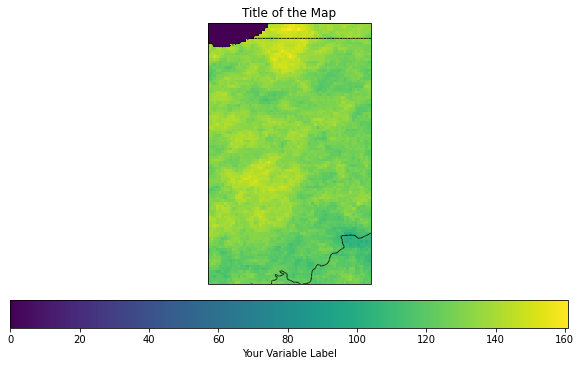

In [152]:
lat = inLat['lat'].values
lon = inLat['lon'].values

# Create the meshgrid
lon, lat = np.meshgrid(lon, lat)
val = inLat.sum(dim='year', skipna=True)
# Create the map
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the data
c = ax.pcolormesh(lon, lat, val, transform=ccrs.PlateCarree(), cmap='viridis')

# Add features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':')

# Add colorbar
cbar = plt.colorbar(c, orientation='horizontal', pad=0.05)
cbar.set_label('Your Variable Label')

# Add a title
plt.title('Title of the Map')

# Save the figure
# plt.savefig('output_map.png', bbox_inches='tight')

# Show the plot
plt.show()
